# Master in Applied Artificial Intelligence

## Course: *Fintech and Digital Innovation in Finance*

### **Course Project – Part 4**
### Advanced RAG techniques & Sentiment Analysis on S&P 500 news (*Section B*)

---

**Institution:** Tecnológico de Monterrey

**Instructors:** Marie-Ève Malette, Yetnalezi Quintas Ruiz

**Author:** Alejandro Díaz Villagómez | A01276769

**Date:** August 18th, 2025

---

# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
# !pip install -q hf_xet yfinance
# !pip freeze > ../requirements.txt

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import yfinance as yf

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [3]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)

print(f"News data shape: {df_news.shape}")
print(f"News date range: {df_news['PUBLICATION_DATE'].min()} to {df_news['PUBLICATION_DATE'].max()}")
print("-" * 30)
display(df_news.head())

News data shape: (3976, 6)
News date range: 2024-07-12 13:22:00+00:00 to 2025-05-31 15:42:42+00:00
------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...


In [4]:
df_meta = pd.read_csv('df_metadata.csv')

print(f"Metadata shape: {df_meta.shape}")
print("-" * 30)
display(df_meta.head())

Metadata shape: (490, 4)
------------------------------


,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [5]:
# CODE HERE
# Use as many coding cells as you need

# Setup
MODEL_NAME = "cross-encoder/nli-deberta-v3-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device).eval()

In [6]:
# Find label indices robustly (models sometimes use different keys)
id2label = model.config.id2label
label2id = {v.lower(): k for k, v in id2label.items()}

def _find_idx(name_candidates):
    for k, v in id2label.items():
        if v.lower() in name_candidates:
            return int(k)
    # Fallback: common ordering is [contradiction, neutral, entailment]
    # but don't rely on it unless we must
    if len(id2label) == 3:
        # Heuristic fallback
        return 2 if "ent" in name_candidates else 0
    raise ValueError("Could not map NLI label indices from model config.")

ENT_IDX = _find_idx({"entailment"})
CON_IDX = _find_idx({"contradiction"})

# Hypotheses
POS_HYP = "This news is good for the company."
NEG_HYP = "This news is bad for the company."

In [7]:
# Batch scoring function
def score_headlines_nli(headlines, batch_size=32, max_length=256):
    """
    Returns two lists: positive_probs, negative_probs
    Each is the entailment probability for (headline, POS/NEG hypothesis).
    """
    pos_probs, neg_probs = [], []

    # Helper to run one hypothesis across a slice of headlines
    def _run_batch(premises, hypothesis):
        enc = tokenizer(
            premises, [hypothesis] * len(premises),
            padding=True, truncation=True, max_length=max_length, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            # Logits are [B, 3] for 3 classes: contradiction, neutral, entailment
            logits = model(**enc).logits
            # Softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Extract entailment probabilities
            entailment = probs[:, ENT_IDX]
        return entailment.detach().cpu().tolist()

    # Iterate in batches
    for i in range(0, len(headlines), batch_size):
        chunk = list(map(str, headlines[i:i+batch_size]))  # ensure strings
        pos_probs.extend(_run_batch(chunk, POS_HYP))
        neg_probs.extend(_run_batch(chunk, NEG_HYP))

    return pos_probs, neg_probs

In [8]:
# Apply to df_news
pos, neg = score_headlines_nli(df_news['SUMMARY'].tolist(), batch_size=32)
df_news['POSITIVE_PROB'] = pos
df_news['NEGATIVE_PROB'] = neg
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

In [9]:
print(f"News sentiment shape: {df_news.shape}")
print(f"News sentiment date range: {df_news['PUBLICATION_DATE'].min()} to {df_news['PUBLICATION_DATE'].max()}")
print("-" * 30)
display(df_news[['SUMMARY', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']].head())

News sentiment shape: (3976, 9)
News sentiment date range: 2024-07-12 13:22:00+00:00 to 2025-05-31 15:42:42+00:00
------------------------------


,SUMMARY,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,The Dow Jones (^DJI) is made up of 30 of the m...,0.000038,0.000122,-0.000084
1,The S&P 500 (^GSPC) is often seen as a benchma...,0.000081,0.000185,-0.000104
2,"MMM is making strides in the aerospace, indust...",0.002505,0.000349,0.002155
3,Quarterly earnings results are a good time to ...,0.000188,0.000054,0.000134
4,While strong cash flow is a key indicator of s...,0.000204,0.000097,0.000108


In [10]:
print("Most positive summaries - Top 5")
print("-" * 30)
top_positive = df_news.nlargest(5, 'SENTIMENT')[['SUMMARY', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']]
display(top_positive)

print("\nMost negative summaries - Top 5")
print("-" * 30)
top_negative = df_news.nsmallest(5, 'SENTIMENT')[['SUMMARY', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']]
display(top_negative)

Most positive summaries - Top 5
------------------------------


,SUMMARY,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
4523,Veralto (NYSE:VLTO) recently announced its Q1 ...,0.992533,0.000218,0.992315
4785,The projects would be a boon for Pennsylvania ...,0.988303,0.000019,0.988284
3242,Commenting on JPMorgan’s recent downgrade on N...,0.986723,0.000044,0.986679
4522,Veralto (NYSE:VLTO) recently announced its ear...,0.980314,0.000460,0.979854
1427,While it may not be enough for some shareholde...,0.965250,0.000039,0.965212



Most negative summaries - Top 5
------------------------------


,SUMMARY,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
3102,The Trump administration’s decision to yank ne...,0.000094,0.983821,-0.983727
760,Weak sales growth has been a thorn in the side...,0.000064,0.975404,-0.975340
1609,Congress is pushing forward a bill that could ...,0.000083,0.963295,-0.963212
186,President Donald Trump’s swipes at Apple aren’...,0.000077,0.825891,-0.825814
4414,Uber Technologies ’ stock is down on news tha...,0.000233,0.284536,-0.284302


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [11]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Aggregate daily sentiment
# Ensure publication date is in datetime
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']) 
daily_sentiment = (
    df_news.groupby(df_news['PUBLICATION_DATE'].dt.date)['SENTIMENT']
    .mean()
    .reset_index()
    .rename(columns={'PUBLICATION_DATE': 'date', 'SENTIMENT': 'avg_sentiment'})
)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print(f"Daily sentiment shape: {daily_sentiment.shape}")
print(f"Daily sentiment date range: {daily_sentiment['date'].min().strftime('%Y-%m-%d')} to {daily_sentiment['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(daily_sentiment.head())

Daily sentiment shape: (118, 2)
Daily sentiment date range: 2024-07-12 to 2025-05-31
------------------------------


,date,avg_sentiment
0,2024-07-12,0.000296
1,2024-07-22,0.000042
2,2024-08-19,0.002900
3,2024-09-13,0.001527
4,2024-10-26,0.000438


In [12]:
# Step 2: Download market data (S&P 500 proxy)
sp500 = yf.download("^GSPC", start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max(), auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [13]:
# Step 3: Compute daily returns (auto_adjust=True implies 'Close' is adjusted)
sp500_returns = (
    sp500[['Close']]  # adjusted close when auto_adjust=True
    .rename(columns={'Close': 'close'})
    .assign(Return=lambda d: d['close'].pct_change())
    .reset_index()
    .rename(columns={'Date': 'date'})
)

print(f"SP500 returns shape: {sp500_returns.shape}")
print("-" * 30)
display(sp500_returns.head())

SP500 returns shape: (222, 3)
------------------------------


Price,date,close,Return
Ticker,,^GSPC,
0,2024-07-12,5615.350098,NaN
1,2024-07-15,5631.220215,0.002826
2,2024-07-16,5667.200195,0.006389
3,2024-07-17,5588.270020,-0.013928
4,2024-07-18,5544.589844,-0.007816


In [14]:
# Step 3.1: yfinance yields MultiIndex columns; flatten is needed
sp500_returns.columns = [c[0] if isinstance(c, tuple) else c for c in sp500_returns.columns]
sp500_returns['date'] = pd.to_datetime(sp500_returns['date'])

print(f"SP500 returns after flattening: {sp500_returns.shape}")
print(f"SP500 returns date range: {sp500_returns['date'].min().strftime('%Y-%m-%d')} to {sp500_returns['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(sp500_returns.head())

SP500 returns after flattening: (222, 3)
SP500 returns date range: 2024-07-12 to 2025-05-30
------------------------------


,date,close,Return
0,2024-07-12,5615.350098,NaN
1,2024-07-15,5631.220215,0.002826
2,2024-07-16,5667.200195,0.006389
3,2024-07-17,5588.270020,-0.013928
4,2024-07-18,5544.589844,-0.007816


In [15]:
# Step 4: Merge daily sentiment with returns
merged = pd.merge(
    daily_sentiment[['date', 'avg_sentiment']].copy(),
    sp500_returns[['date', 'Return']].copy(),
    on='date',
    how='inner'
).sort_values('date').reset_index(drop=True)

print(f"Merged data shape: {merged.shape}")
print(f"Merged data date range: {merged['date'].min().strftime('%Y-%m-%d')} to {merged['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(merged.head(10))

Merged data shape: (83, 3)
Merged data date range: 2024-07-12 to 2025-05-30
------------------------------


,date,avg_sentiment,Return
0,2024-07-12,0.000296,NaN
1,2024-07-22,0.000042,0.010792
2,2024-08-19,0.002900,0.009722
3,2024-09-13,0.001527,0.005408
4,2024-11-12,0.000689,-0.002893
5,2024-12-11,-0.000034,0.008166
6,2024-12-16,0.000754,0.003799
7,2024-12-20,-0.000022,0.010869
8,2025-01-02,0.000098,-0.002224
9,2025-01-03,0.000024,0.012596


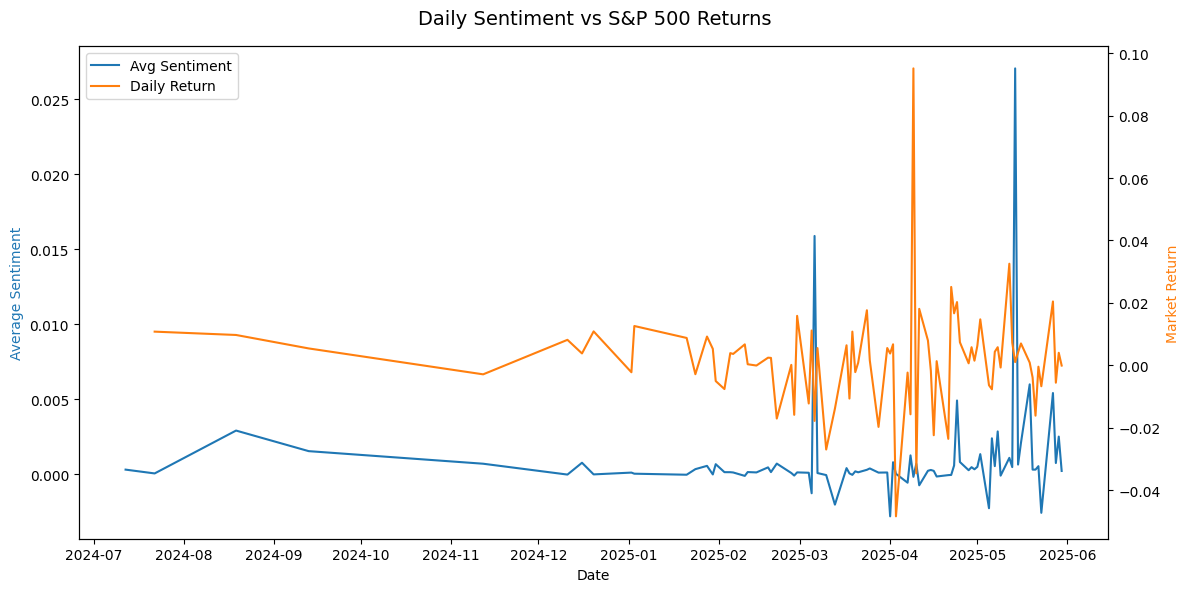

In [16]:
# Step 5: Visualization 
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: sentiment
ax1.plot(merged['date'], merged['avg_sentiment'], color='tab:blue', label='Avg Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='y')

# Right y-axis: returns
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['Return'], color='tab:orange', label='Daily Return')
ax2.set_ylabel('Market Return', color='tab:orange')
# ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.tick_params(axis='y')

# Add title & legend
fig.suptitle("Daily Sentiment vs S&P 500 Returns", fontsize=14)
l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lb1 + lb2, loc='upper left')
plt.tight_layout()

plt.show()

The time series analysis reveals distinct temporal patterns in both sentiment and market behavior across the observation period from July 2024 to June 2025. During the initial phase (July-December 2024), average sentiment demonstrates relatively stable dynamics, fluctuating within a narrow band near zero with a slight declining trend. Concurrently, S&P 500 daily returns exhibit moderate volatility with intermittent spikes, maintaining a generally contained range of approximately ±1%.

A notable shift occurs beginning in early 2025, characterized by significantly increased market volatility and more pronounced sentiment fluctuations. The period from March to June 2025 shows particularly heightened activity, with daily returns experiencing extreme movements reaching approximately ±10%, while sentiment scores display greater variability and occasional sharp deviations from the baseline. This period suggests potential market stress or significant news events driving both sentiment and price movements.

The visual examination suggests limited systematic co-movement between daily sentiment and market returns throughout most of the observation period. While both series exhibit increased volatility in the latter months, the temporal alignment of peaks and troughs appears inconsistent, indicating that the relationship between news sentiment and same-day market performance may be more complex than a simple linear correlation would suggest. The divergent scaling and volatility patterns underscore the importance of further quantitative analysis to assess any potential predictive relationships.

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [17]:
# CODE HERE
# Use as many coding cells as you need

# 1) Collect tickers from df_meta (robust to column naming)
tickers = (
    df_meta['TICKER'].dropna().astype(str).str.strip().str.upper()
    .str.replace(r'\s+', '', regex=True)
    .str.replace('.', '-', regex=False)  # yfinance uses '-' for class shares, e.g., BRK-B
    .unique().tolist()
)

start = pd.to_datetime(daily_sentiment['date']).min()
end   = pd.to_datetime(daily_sentiment['date']).max()

print(f"Collecting tickers from metadata: {len(tickers)} found")
print(f"Date range: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

Date range: 2024-07-12 to 2025-05-31


In [18]:
# 2) Download prices (equal-weight universe = all tickers found). Fallback to ^GSPC if none.
prices = yf.download(
    tickers=tickers, 
    start=start, 
    end=end, 
    auto_adjust=True, 
    group_by="ticker", 
    threads=True
)

print(f"Prices shape: {prices.shape}")
print(f"Prices date range: {prices.index.min().strftime('%Y-%m-%d')} to {prices.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(prices.head())

[*********************100%***********************]  490 of 490 completed

Prices shape: (222, 2450)
Prices date range: 2024-07-12 to 2025-05-30
------------------------------


Ticker            CRWD                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2024-07-12  368.200012  374.489990  367.755005  371.320007  2609700   
2024-07-15  371.670013  383.570007  364.209991  377.369995  3522400   
2024-07-16  378.239990  379.334991  368.500000  369.049988  2606300   
2024-07-17  360.000000  363.596985  350.720001  354.940002  3498700   
2024-07-18  351.739990  352.200012  336.339996  343.049988  4552800   

Ticker            KMI                                             ...  \
Price            Open       High        Low      Close    Volume  ...   
Date                                                              ...   
2024-07-12  19.130170  19.196298  18.979018  19.073488  18489400  ...   
2024-07-15  19.158512  19.252980  19.035700  19.054594  13844400  ...   
2024-07-16  19.413582  19.413582  18.922340  19.120726  14691300  ...   
2024-07-17  19.177403  19.432473  19.149064  19.394686  23408500  ...   
2024-07-18  19.366347  20.263812  19.309665  19.885931  42322400  ...   

Ticker              RL                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2024-07-12  183.099062  183.099062  178.379193  178.921143   599600   
2024-07-15  175.186625  177.344559  168.121616  168.555176  1120700   
2024-07-16  169.471566  171.856129  166.889921  170.653992  1193700   
2024-07-17  167.865445  170.486499  166.348002  167.234818  1061500   
2024-07-18  168.101917  171.649193  164.771405  165.313354   659200   

Ticker             MPC                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2024-07-12  161.788801  162.072497  158.589804  161.867065  2256500  
2024-07-15  163.197517  164.997558  162.463803  163.089905  2198800  
2024-07-16  161.935523  164.342111  160.223524  164.029053  2271600  
2024-07-17  164.351908  168.734621  160.605074  161.964890  3218600  
2024-07-18  163.373607  164.596463  160.468099  160.947464  3014600  

[5 rows x 2450 columns]

In [19]:
# 3) Extract Close matrix (handles multi-ticker frames)
close = prices.xs('Close', axis=1, level=1).copy()

# Clean index/timezone; drop days with no data for all tickers
close.index = pd.to_datetime(close.index).tz_localize(None)
close = close.dropna(how='all')

print(f"Prices shape: {close.shape}")
print(f"Prices date range: {close.index.min().strftime('%Y-%m-%d')} to {close.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(close.head())

Prices shape: (222, 490)
Prices date range: 2024-07-12 to 2025-05-30
------------------------------


Ticker,CRWD,KMI,AMT,MAR,HPE,GWW,TYL,VMC,NXPI,AXON,...,FOXA,XYL,NDSN,GE,DG,RF,KEY,GM,RL,MPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,371.320007,19.073488,203.951233,240.397552,20.570997,908.989014,523.080017,250.176025,275.052704,292.660004,...,35.324409,136.805130,233.813629,157.991486,128.976212,19.622681,14.493028,48.499508,178.921143,161.867065
2024-07-15,377.369995,19.054594,202.237183,244.239304,20.833361,933.058228,520.909973,251.553177,277.585388,308.640015,...,35.581463,135.698212,233.300949,158.537949,123.658211,20.130741,14.769357,48.786488,168.555176,163.089905
2024-07-16,369.049988,19.120726,203.505753,252.596161,20.823643,977.881104,528.919983,260.380798,285.448517,319.429993,...,36.313057,139.612000,239.936249,161.806900,124.164688,20.868870,15.236259,49.251591,170.653992,164.029053
2024-07-17,354.940002,19.394686,206.381882,245.110641,20.221184,964.767761,528.030029,253.435638,271.224213,317.779999,...,37.024887,137.378372,239.926407,155.656540,121.125832,21.194798,15.445887,49.380241,167.234818,161.964890
2024-07-18,343.049988,19.885931,203.989960,241.684738,20.085146,947.487793,525.909973,253.722961,274.149567,305.670013,...,36.678860,136.429565,236.278458,157.772888,118.408386,21.175623,14.826529,49.132843,165.313354,160.947464


In [20]:
# 4) Equal-weight daily return and cumulative portfolio value (start at 1.0)
ret = close.pct_change()
avg_ret = ret.mean(axis=1, skipna=True).dropna() # average across tickers each day
portfolio_value = (1.0 + avg_ret).cumprod().rename('portfolio_value')
portfolio_df = portfolio_value.to_frame()
portfolio_df['date'] = portfolio_df.index

print(f"Portfolio value shape: {portfolio_df.shape}")
print(f"Portfolio value date range: {portfolio_df['date'].min().strftime('%Y-%m-%d')} to {portfolio_df['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(portfolio_df.head())

Portfolio value shape: (221, 2)
Portfolio value date range: 2024-07-15 to 2025-05-30
------------------------------


,portfolio_value,date
Date,,
2024-07-15,1.001197,2024-07-15
2024-07-16,1.018191,2024-07-16
2024-07-17,1.013614,2024-07-17
2024-07-18,1.004839,2024-07-18
2024-07-19,0.998813,2024-07-19


In [21]:
# 5) Merge with daily sentiment (inner join on trading days)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.tz_localize(None)
viz = (daily_sentiment[['date','avg_sentiment']]
       .merge(portfolio_df[['date','portfolio_value']], on='date', how='inner')
       .sort_values('date').reset_index(drop=True))

print(f"Visualization data shape: {viz.shape}")
print(f"Date range: {viz['date'].min().strftime('%Y-%m-%d')} to {viz['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(viz.head())

Visualization data shape: (82, 3)
Date range: 2024-07-22 to 2025-05-30
------------------------------


,date,avg_sentiment,portfolio_value
0,2024-07-22,0.000042,1.007599
1,2024-08-19,0.002900,1.024646
2,2024-09-13,0.001527,1.041300
3,2024-11-12,0.000689,1.101939
4,2024-12-11,-0.000034,1.105393


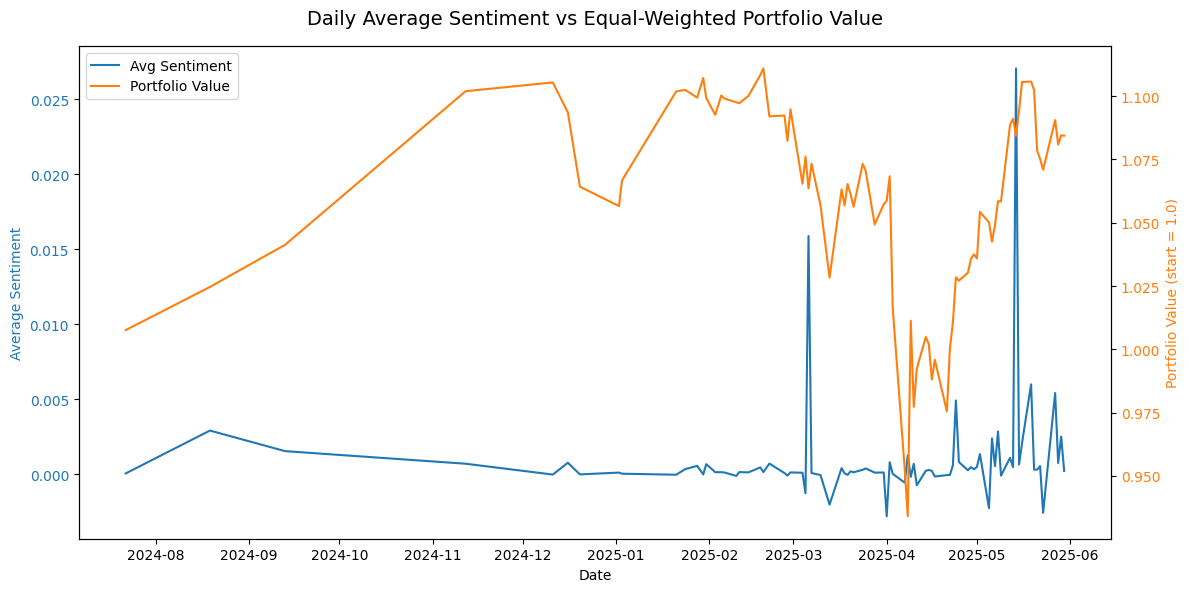

In [22]:
# 6) Dual-axis plot: sentiment (left) vs portfolio value (right)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(viz['date'], viz['avg_sentiment'], label='Avg Sentiment', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(viz['date'], viz['portfolio_value'], label='Portfolio Value', color='tab:orange')
ax2.set_ylabel('Portfolio Value (start = 1.0)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.suptitle('Daily Average Sentiment vs Equal-Weighted Portfolio Value', fontsize=14)
l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lb1 + lb2, loc='upper left')
plt.tight_layout()
plt.show()

The figure contrasts daily average news sentiment with the value of an equal-weighted portfolio (base = 1.0). From July to November 2024 the portfolio trends upward while sentiment remains near zero with low dispersion, indicating that early performance was not mirrored by headline sentiment. Beginning around late 2024/early 2025, both series display greater variability; the portfolio experiences material drawdowns and subsequent recoveries, while sentiment exhibits intermittent spikes that occasionally coincide with turning points.

Visual inspection suggests limited and sporadic co-movement rather than a stable same-day relationship. Given the dual-axis scaling and several extreme observations, these patterns should be interpreted cautiously; normalizing both series and testing lead–lag relations (e.g., predictive regressions or quantile-sorted strategies) would provide a more reliable assessment of whether sentiment carries timing information or primarily signals volatility regimes.

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [23]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Normalize tickers and determine relevant information
def norm_ticker(s):
    return (
        s.astype(str).str.upper().str.strip()
        .str.replace(r'\s+', '', regex=True)
        .str.replace('.', '-', regex=False)
    )

# Normalize tickers in both tables
df_news['TICKER'] = norm_ticker(df_news['TICKER'])
df_meta['TICKER'] = norm_ticker(df_meta['TICKER'])

# Determine target year and months
target_year = 2025
months_target = [2, 3, 4, 5] # Feb - May

In [24]:
# Step 2: Group news by sector and calculate monthly sentiment (Feb–May 2025)
news_sector = (df_news.merge(
    df_meta[['TICKER', 'SECTOR']].dropna(),
    left_on='TICKER', right_on='TICKER', how='left')
    .rename(columns={'SECTOR': 'SECTOR'})
)

mask_months = (news_sector['PUBLICATION_DATE'].dt.year == target_year) & \
    (news_sector['PUBLICATION_DATE'].dt.month.isin(months_target))

news_feb_may = news_sector.loc[mask_months].copy()
news_feb_may['month'] = news_feb_may['PUBLICATION_DATE'].dt.to_period('M').dt.to_timestamp('M')

monthly_sector_sent = (
    news_feb_may.groupby(['SECTOR','month'], dropna=True)
    .agg(SENTIMENT=('SENTIMENT','mean'), HEADLINES=('SENTIMENT','size'))  # HEADLINES is optional
    .reset_index()
)

print(f"Monthly sector sentiment shape: {monthly_sector_sent.shape}")
print(f"Monthly sector sentiment date range: {monthly_sector_sent['month'].min().strftime('%Y-%m-%d')} to {monthly_sector_sent['month'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(monthly_sector_sent.head(10))

Monthly sector sentiment shape: (39, 4)
Monthly sector sentiment date range: 2025-02-28 to 2025-05-31
------------------------------


/var/folders/zb/tl73nj3d2933b0zx9fk5tfbm0000gn/T/ipykernel_71097/2059673792.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  news_feb_may['month'] = news_feb_may['PUBLICATION_DATE'].dt.to_period('M').dt.to_timestamp('M')


,SECTOR,month,SENTIMENT,HEADLINES
0,Basic Materials,2025-02-28,-0.000122,1
1,Basic Materials,2025-03-31,-0.000197,4
2,Basic Materials,2025-04-30,-0.000030,10
3,Basic Materials,2025-05-31,0.001205,135
4,Communication Services,2025-03-31,0.000328,1
5,Communication Services,2025-04-30,0.000259,5
6,Communication Services,2025-05-31,0.001323,144
7,Consumer Cyclical,2025-02-28,0.000119,3
8,Consumer Cyclical,2025-03-31,-0.000702,4
9,Consumer Cyclical,2025-04-30,0.000260,18


In [25]:
# May sentiment by sector
may_sent = (
    monthly_sector_sent
    .loc[monthly_sector_sent['month'].dt.month == 5, ['SECTOR','SENTIMENT','HEADLINES']]
    .rename(columns={'SENTIMENT':'SENTIMENT'})
)

print(f"May sentiment shape: {may_sent.shape}")
print("-" * 30)
display(may_sent.sort_values('SENTIMENT', ascending=False).head(10))

May sentiment shape: (11, 3)
------------------------------


,SECTOR,SENTIMENT,HEADLINES
27,Industrials,0.008002,539
16,Energy,0.006071,172
13,Consumer Defensive,0.005772,270
34,Technology,0.001646,636
20,Financial Services,0.001397,453
6,Communication Services,0.001323,144
3,Basic Materials,0.001205,135
31,Real Estate,0.000782,188
38,Utilities,0.000627,209
23,Healthcare,-0.001707,446


In [26]:
# Step 3: Compute monthly stock returns from price data and extract May returns

# Create universe of tickers and download prices
universe = df_meta.dropna(subset=['TICKER', 'SECTOR']).copy()
tickers = universe['TICKER'].unique().tolist()

start_prices = pd.Timestamp(target_year, 1, 1)
end_prices = pd.Timestamp(target_year, 5, 31) + pd.Timedelta(days=1)  # Includes all of May

prices = yf.download(
    tickers=tickers, 
    start=start_prices, 
    end=end_prices,
    auto_adjust=True, 
    group_by="ticker", 
    threads=True
)

print(f"Prices shape: {prices.shape}")
print(f"Prices date range: {prices.index.min().strftime('%Y-%m-%d')} to {prices.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(prices.head())

[*********************100%***********************]  490 of 490 completed


Prices shape: (102, 2450)
Prices date range: 2025-01-02 to 2025-05-30
------------------------------


Ticker             AMT                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-01-02  181.161915  181.752378  177.697914  178.150589  3142800   
2025-01-03  178.367074  180.807623  177.245207  179.656235  1817300   
2025-01-06  178.681998  180.561607  177.009026  177.392822  2262400   
2025-01-07  177.264900  178.081700  174.086265  174.351974  2096000   
2025-01-08  173.741851  176.467796  172.000000  176.339859  2048300   

Ticker            NXPI                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2025-01-02  207.615769  209.586842  203.277436  204.248123  1424300  ...   
2025-01-03  205.327754  208.140730  203.049633  206.872910  2308100  ...   
2025-01-06  208.011977  213.855854  208.011977  211.379639  1972700  ...   
2025-01-07  211.845161  216.857017  209.230278  210.557526  2312200  ...   
2025-01-08  210.121706  211.290487  205.367370  207.724731  2302600  ...   

Ticker            NDSN                                                     DG  \
Price             Open        High         Low       Close  Volume       Open   
Date                                                                            
2025-01-02  208.095180  209.187080  202.764756  203.459595  228600  74.839500   
2025-01-03  203.797082  206.328295  202.695261  206.030502  263200  74.456962   
2025-01-06  207.122391  209.673445  204.640813  205.434921  260300  73.485903   
2025-01-07  205.266162  207.072758  202.973187  203.916183  257000  74.783641   
2025-01-08  203.280916  204.333117  200.332815  200.600815  431300  72.944944   

Ticker                                                
Price            High        Low      Close   Volume  
Date                                                  
2025-01-02  76.546192  73.799785  74.182320  2673700  
2025-01-03  74.456962  73.024902  73.240692  3120000  
2025-01-06  75.967474  73.034709  74.398102  3234400  
2025-01-07  77.106727  73.231621  73.320587  3592200  
2025-01-08  73.152538  69.346631  70.799797  5786100  

[5 rows x 2450 columns]

In [27]:
# Extract Close matrix 
close = prices.xs('Close', axis=1, level=1).copy()
close.index = pd.to_datetime(close.index).tz_localize(None)
close = close.dropna(how='all')

# Compute monthly returns (last of month)
close_m = close.resample('ME').last()
ret_m = close_m.pct_change()

# Filter Feb–May 2025
ret_m = ret_m[(ret_m.index.year == target_year) & (ret_m.index.month.isin(months_target))]

# Map to long format, map sector, and average by sector-month (equal-weight)
ret_long = (
    ret_m.stack().rename('RETURN').reset_index()
    .rename(columns={'Ticker':'TICKER','Date':'month'})
)
ret_long['TICKER'] = norm_ticker(ret_long['TICKER'])

ticker_to_sector = universe[['TICKER', 'SECTOR']].dropna().rename(
    columns={'TICKER':'TICKER', 'SECTOR':'SECTOR'}
)

ret_with_sector = ret_long.merge(ticker_to_sector, on='TICKER', how='left')

sector_monthly_returns = (
    ret_with_sector.groupby(['SECTOR','month'], dropna=True)
    .agg(RETURN=('RETURN','mean'),N_TICKERS=('RETURN','count'))
    .reset_index()
)

# May returns by sector
may_rets = sector_monthly_returns.loc[
    sector_monthly_returns['month'].dt.month == 5, ['SECTOR','RETURN','N_TICKERS']
]

print(f"May returns by sector: {may_rets.shape}")
print("-" * 30)
display(may_rets.sort_values('RETURN', ascending=False).head(10))

May returns by sector: (11, 3)
------------------------------


,SECTOR,RETURN,N_TICKERS
39,Technology,0.075285,81
31,Industrials,0.074589,70
23,Financial Services,0.061068,66
11,Consumer Cyclical,0.056382,55
7,Communication Services,0.043514,23
43,Utilities,0.032967,30
3,Basic Materials,0.029613,19
19,Energy,0.029434,21
35,Real Estate,0.010360,31
27,Healthcare,0.000100,58


In [28]:
# Step 4: Compare May sentiment and returns by sector
comparison = (may_sent.merge(may_rets, on='SECTOR', how='inner')
              .sort_values('RETURN', ascending=False)
              .reset_index(drop=True))

print(f"Sectors in comparison: {comparison['SECTOR'].nunique()}")
print(f"Comparison shape: {comparison.shape}")
print("-" * 30)
display(comparison)

Sectors in comparison: 11
Comparison shape: (11, 5)
------------------------------


,SECTOR,SENTIMENT,HEADLINES,RETURN,N_TICKERS
0,Technology,0.001646,636,0.075285,81
1,Industrials,0.008002,539,0.074589,70
2,Financial Services,0.001397,453,0.061068,66
3,Consumer Cyclical,-0.002116,409,0.056382,55
4,Communication Services,0.001323,144,0.043514,23
5,Utilities,0.000627,209,0.032967,30
6,Basic Materials,0.001205,135,0.029613,19
7,Energy,0.006071,172,0.029434,21
8,Real Estate,0.000782,188,0.010360,31
9,Healthcare,-0.001707,446,0.000100,58


In [29]:
# Step 5: Correlation between May sector sentiment and returns
valid = comparison[['SENTIMENT','RETURN']].dropna()
corr = valid['SENTIMENT'].corr(valid['RETURN'])
print(f"Correlation (May sector sentiment vs May sector returns): {corr:.4f}")

Correlation (May sector sentiment vs May sector returns): 0.1410


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


**RESPONSE**

The sectors that exhibited the most positive sentiment in May 2025 news coverage were Industrials (0.008002), Energy (0.006071), and Consumer Defensive (0.005772). However, their market performance revealed significant disconnects between media perception and actual returns: 

* Industrials demonstrated exceptional alignment, ranking first in sentiment and delivering the second-highest returns (7.46%). 

* Energy, despite ranking second in positive sentiment, significantly underperformed with returns of only 2.94%, placing it eighth out of eleven sectors. 

* Most notably, Consumer Defensive exhibited the third-highest positive sentiment but delivered virtually flat performance (0.0008%), ranking last in returns. 

This divergence suggests that positive media coverage in certain sectors, particularly Energy and Consumer Defensive, did not translate into corresponding market outperformance during the analyzed period.

### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


**RESPONSE**

* Technology stands as the most compelling example of strong performance despite neutral sentiment, delivering the highest returns (7.53%) while maintaining relatively modest positive sentiment (0.001646). 

* Similarly, Consumer Cyclical achieved robust returns (5.64%) despite actually experiencing negative sentiment (-0.002116), demonstrating that adverse media coverage did not impede market performance. 

* Financial Services also exemplified this pattern, generating strong returns (6.11%) with only marginally positive sentiment (0.001397). 

These sectors suggest that fundamental business performance and market dynamics can override negative or neutral media sentiment, indicating that investor decision-making may be driven more by financial metrics and sector-specific catalysts than by general news tone.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

**RESPONSE**

Investment decisions based solely on sentiment analysis would be fundamentally flawed, as evidenced by the weak correlation (0.1410) between May sentiment and returns observed in this analysis. The data demonstrates multiple instances where sentiment and performance diverged significantly, such as Energy's positive sentiment yielding poor returns and Technology's neutral sentiment generating exceptional performance. Sentiment analysis should serve as one component within a comprehensive investment framework that incorporates fundamental analysis, technical indicators, macroeconomic factors, and risk management principles. While sentiment can provide valuable insights into market psychology and potential contrarian opportunities, relying exclusively on media tone ignores critical financial metrics, competitive positioning, and sector-specific dynamics that ultimately drive long-term value creation.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

**RESPONSE**

To test a sentiment analysis strategy in a more robust manner, a multi-faceted approach is necessary, moving beyond a simple one-month correlation.

* **Expand the Analysis Horizon:** Instead of focusing on a single month, evaluate the correlation between sentiment and returns over a longer period (e.g., several years) to identify more stable, long-term relationships. This would help mitigate the impact of short-term market noise or idiosyncratic events.

* **Lagged Correlation Analysis:** Test for a lagged relationship between sentiment and returns. It is unlikely that sentiment and returns would move concurrently. A more realistic hypothesis is that news sentiment acts as a leading indicator, influencing returns in the following days or weeks. For example, one could analyze whether positive sentiment in week 1 correlates with positive returns in week 2.

* **Cross-Sectional and Time-Series Analysis:** Combine cross-sectional and time-series data. This involves analyzing sentiment-return relationships for multiple sectors over time. This approach would help determine if the relationship is consistent across different sectors and market conditions.

* **Incorporate Additional Data:** Augment the sentiment data with other factors that influence returns, such as macroeconomic indicators (e.g., interest rates, inflation), company-specific financial data (e.g., earnings reports), and analyst ratings. A regression model could be used to determine the predictive power of sentiment after controlling for these other variables.

* **Develop and Backtest a Trading Strategy:** The ultimate test of a sentiment strategy is its ability to generate alpha in a simulated trading environment. This would involve creating a rule-based strategy (e.g., "buy sectors with a sentiment score above X and sell those below Y") and backtesting it on historical data to evaluate its risk-adjusted returns, such as the Sharpe Ratio and maximum drawdown. This would provide a more practical and reliable measure of the strategy's viability.